# Import Packages

In [16]:
import pandas as pd
import numpy as np
import yfinance as yf
import math
from pandas_datareader import data as pdr
from faker import Faker
import matplotlib.pyplot as plt
import ta
import datetime

Set Date Range

In [17]:
fake = Faker()
start_date = fake.date_between(start_date=datetime.date(2010,1,1), end_date='now')
end_date = fake.date_between(start_date=start_date, end_date='now')

#df = yf.Ticker("SPY").history(period = '3y', interval = '1d').reset_index()[["Date", "Close"]]
df = pdr.get_data_yahoo("SPY", start=start_date,  end=end_date).reset_index()[["Date", "Close"]]

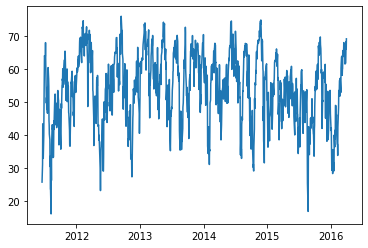

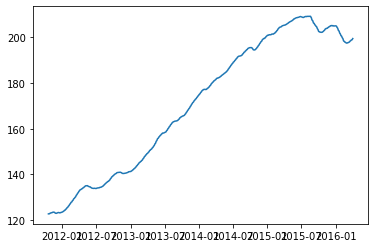

In [18]:
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window = 14).rsi()
plt.plot(df['Date'], df['RSI'])
plt.show()


df['EMA100'] = ta.trend.EMAIndicator(df['Close'], window = 100).ema_indicator()
plt.plot(df['Date'], df['EMA100'])
plt.show()

In [19]:
df['MACD'] = ta.trend.MACD(df['Close']).macd()
df['Signal'] = ta.trend.MACD(df['Close']).macd_signal()
df['MACD_Diff'] = ta.trend.MACD(df['Close']).macd_diff()
df


,Date,Close,RSI,EMA100,MACD,Signal,MACD_Diff
0,2011-05-31,134.899994,NaN,NaN,NaN,NaN,NaN
1,2011-06-01,131.869995,NaN,NaN,NaN,NaN,NaN
2,2011-06-02,131.729996,NaN,NaN,NaN,NaN,NaN
3,2011-06-03,130.419998,NaN,NaN,NaN,NaN,NaN
4,2011-06-06,129.039993,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1213,2016-03-28,203.240005,61.936463,198.843852,2.559564,2.670081,-0.110517
1214,2016-03-29,205.119995,66.493657,198.968132,2.567843,2.649633,-0.081791
1215,2016-03-30,206.020004,68.441614,199.107773,2.616862,2.643079,-0.026217
1216,2016-03-31,205.520004,66.141066,199.234748,2.585559,2.631575,-0.046016


Strategy 1: Pure MACD

In [20]:
debug = False
adaptive_stoploss = False
buy = False
sell = False
stoploss = None
max_profit = None
buy_list = []
sell_list = []

for i in range(len(df)):
    #print(df.Date[i], df.Close[i])
    
    if buy == True and df.Close[i] <= stoploss:
        sell_list.append(df.Close[i])
        buy_list.append(np.nan)
        stoploss = None
        max_profit = None
        buy = False    
        if debug:
            print("Stoploss Hit - Sell at $", df.Close[i])
        
    elif buy == True and df.Close[i] >= max_profit:
        if adaptive_stoploss:
            stoploss = df.Close[i] * 0.99
            max_profit = df.Close[i] * 1.03
            buy_list.append(np.nan)
            sell_list.append(np.nan)
            if debug: 
                print("Max Profit Reached - Updated Stoploss")         
        else:
            sell_list.append(df.Close[i])
            buy_list.append(np.nan)
            stoploss = None
            max_profit = None
            buy = False   
            if debug: 
                print("Max Profit Reached - Sell at $", df.Close[i])
        
    elif df.MACD_Diff[i] > df.Signal[i] and buy == False:
        buy_list.append(df.Close[i])
        sell_list.append(np.nan)
        stoploss = df.Close[i] * 0.99
        max_profit = df.Close[i] * 1.03
        buy = True
        if debug:
            print("Buy at $", df.Close[i])
            
    elif df.MACD_Diff[i] < df.Signal[i] and buy == True:
        sell_list.append(df.Close[i])
        buy_list.append(np.nan)
        stoploss = None
        max_profit = None
        buy = False
        if debug:
            print("Momentum Changed - Sell at $", df.Close[i])
    else:
        buy_list.append(np.nan)
        sell_list.append(np.nan)
        
        
df['Buy_Signal_Price'] = buy_list
df['Sell_Signal_Price'] = sell_list

Buys = [x for x in df['Buy_Signal_Price']  if math.isnan(x) == False]
Sells = [x for x in df['Sell_Signal_Price']  if math.isnan(x) == False]

if len(Buys) - len(Sells) == 1:
    Buys = Buys[:-1]
    
profit1 = sum(Sells) - sum(Buys)
print('Profit: ', profit1)


Profit:  44.76007080078125


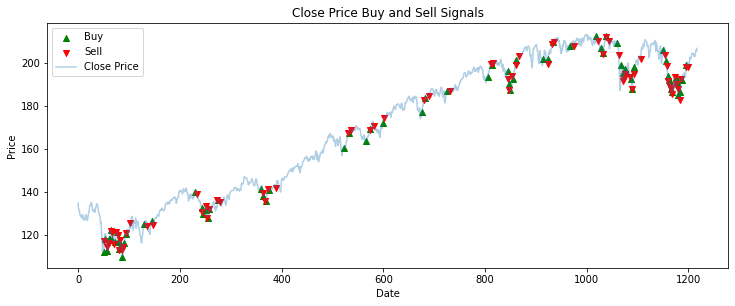

In [21]:

plt.figure(figsize=(12.2,4.5))
plt.scatter(df.index, df['Buy_Signal_Price'], color = 'green', label = 'Buy', marker = '^', alpha = 1)
plt.scatter(df.index, df['Sell_Signal_Price'], color = 'red', label = 'Sell', marker = 'v', alpha = 1)
plt.plot(df['Close'], label = 'Close Price', alpha = 0.35)
plt.title("Close Price Buy and Sell Signals")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc = "upper left")
plt.show()

Strategy 2 MACD + EMA100

In [22]:
debug = False
adaptive_stoploss = False
buy = False
sell = False
stoploss = None
max_profit = None
buy_list = []
sell_list = []

for i in range(len(df)):
    #print(df.Date[i], df.Close[i])
    
    if buy == True and df.Close[i] <= stoploss:
        sell_list.append(df.Close[i])
        buy_list.append(np.nan)
        stoploss = None
        max_profit = None
        buy = False    
        if debug:
            print("Stoploss Hit - Sell at $", df.Close[i])
        
    elif buy == True and df.Close[i] >= max_profit:
        if adaptive_stoploss:
            stoploss = df.Close[i] * 0.99
            max_profit = df.Close[i] * 1.03
            buy_list.append(np.nan)
            sell_list.append(np.nan)
            if debug: 
                print("Max Profit Reached - Updated Stoploss")         
        else:
            sell_list.append(df.Close[i])
            buy_list.append(np.nan)
            stoploss = None
            max_profit = None
            buy = False   
            if debug: 
                print("Max Profit Reached - Sell at $", df.Close[i])
        
    elif df.MACD_Diff[i] > df.Signal[i] and buy == False and df.Close[i] > df.EMA100[i]:
        buy_list.append(df.Close[i])
        sell_list.append(np.nan)
        stoploss = df.Close[i] * 0.99
        max_profit = df.Close[i] * 1.03
        buy = True
        if debug:
            print("Buy at $", df.Close[i])
            
    elif ( df.Close[i] < df.EMA100[i] or df.MACD_Diff[i] < df.Signal[i] ) and buy == True:
        sell_list.append(df.Close[i])
        buy_list.append(np.nan)
        stoploss = None
        max_profit = None
        buy = False
        if debug:
            print("Momentum Changed - Sell at $", df.Close[i])
    else:
        buy_list.append(np.nan)
        sell_list.append(np.nan)
        
        
df['Buy_Signal_Price'] = buy_list
df['Sell_Signal_Price'] = sell_list

Buys = [x for x in df['Buy_Signal_Price']  if math.isnan(x) == False]
Sells = [x for x in df['Sell_Signal_Price']  if math.isnan(x) == False]

if len(Buys) - len(Sells) == 1:
    Buys = Buys[:-1]

profit2 = sum(Sells) - sum(Buys)
print('Profit: ', profit2)


Profit:  21.530006408691406


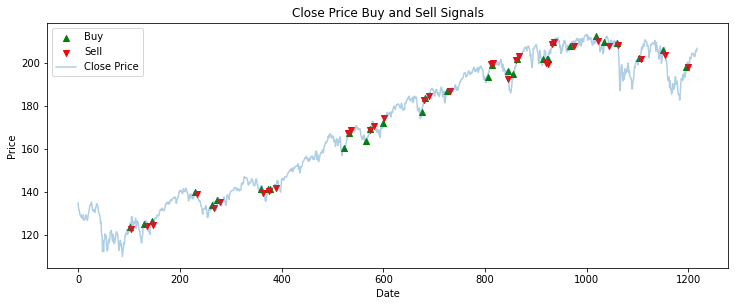

In [23]:

plt.figure(figsize=(12.2,4.5))
plt.scatter(df.index, df['Buy_Signal_Price'], color = 'green', label = 'Buy', marker = '^', alpha = 1)
plt.scatter(df.index, df['Sell_Signal_Price'], color = 'red', label = 'Sell', marker = 'v', alpha = 1)
plt.plot(df['Close'], label = 'Close Price', alpha = 0.35)
plt.title("Close Price Buy and Sell Signals")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc = "upper left")
plt.show()

Strategy 3: MACD + RSI (Used to indicated Overbought or Oversold)

In [24]:
debug = False
adaptive_stoploss = False
buy = False
sell = False
stoploss = None
max_profit = None
buy_list = []
sell_list = []

for i in range(len(df)):
    #print(df.Date[i], df.Close[i])
    
    if buy == True and df.Close[i] <= stoploss:
        sell_list.append(df.Close[i])
        buy_list.append(np.nan)
        stoploss = None
        max_profit = None
        buy = False    
        if debug:
            print("Stoploss Hit - Sell at $", df.Close[i])
        
    elif buy == True and df.Close[i] >= max_profit:
        if adaptive_stoploss:
            stoploss = df.Close[i] * 0.99
            max_profit = df.Close[i] * 1.03
            buy_list.append(np.nan)
            sell_list.append(np.nan)
            if debug: 
                print("Max Profit Reached - Updated Stoploss")         
        else:
            sell_list.append(df.Close[i])
            buy_list.append(np.nan)
            stoploss = None
            max_profit = None
            buy = False   
            if debug: 
                print("Max Profit Reached - Sell at $", df.Close[i])
        
    elif df.MACD_Diff[i] > df.Signal[i] and buy == False and df.RSI[i] < 30:
        buy_list.append(df.Close[i])
        sell_list.append(np.nan)
        stoploss = df.Close[i] * 0.99
        max_profit = df.Close[i] * 1.03
        buy = True
        if debug:
            print("Buy at $", df.Close[i])
            
    elif df.MACD_Diff[i] < df.Signal[i] and buy == True:
        sell_list.append(df.Close[i])
        buy_list.append(np.nan)
        stoploss = None
        max_profit = None
        buy = False
        if debug:
            print("Momentum Changed - Sell at $", df.Close[i])
    else:
        buy_list.append(np.nan)
        sell_list.append(np.nan)
        
        
df['Buy_Signal_Price'] = buy_list
df['Sell_Signal_Price'] = sell_list

Buys = [x for x in df['Buy_Signal_Price']  if math.isnan(x) == False]
Sells = [x for x in df['Sell_Signal_Price']  if math.isnan(x) == False]

if len(Buys) - len(Sells) == 1:
    Buys = Buys[:-1]

profit3 = sum(Sells) - sum(Buys)
print('Profit: ', profit3)

Profit:  24.250038146972656


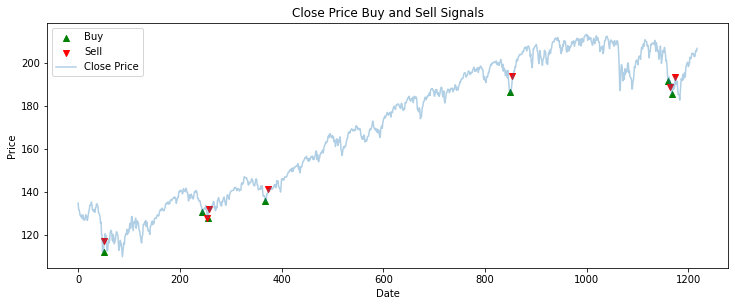

In [25]:

plt.figure(figsize=(12.2,4.5))
plt.scatter(df.index, df['Buy_Signal_Price'], color = 'green', label = 'Buy', marker = '^', alpha = 1)
plt.scatter(df.index, df['Sell_Signal_Price'], color = 'red', label = 'Sell', marker = 'v', alpha = 1)
plt.plot(df['Close'], label = 'Close Price', alpha = 0.35)
plt.title("Close Price Buy and Sell Signals")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc = "upper left")
plt.show()

Strategy 4 MACD + RSI(Used as Trend)

In [26]:
debug = False
adaptive_stoploss = False
buy = False
sell = False
stoploss = None
max_profit = None
buy_list = []
sell_list = []

for i in range(len(df)):
    #print(df.Date[i], df.Close[i])
    
    if buy == True and df.Close[i] <= stoploss:
        sell_list.append(df.Close[i])
        buy_list.append(np.nan)
        stoploss = None
        max_profit = None
        buy = False    
        if debug:
            print("Stoploss Hit - Sell at $", df.Close[i])
        
    elif buy == True and df.Close[i] >= max_profit:
        if adaptive_stoploss:
            stoploss = df.Close[i] * 0.99
            max_profit = df.Close[i] * 1.03
            buy_list.append(np.nan)
            sell_list.append(np.nan)
            if debug: 
                print("Max Profit Reached - Updated Stoploss")         
        else:
            sell_list.append(df.Close[i])
            buy_list.append(np.nan)
            stoploss = None
            max_profit = None
            buy = False   
            if debug: 
                print("Max Profit Reached - Sell at $", df.Close[i])
        
    elif df.MACD_Diff[i] > df.Signal[i] and buy == False and df.RSI[i] > 50:
        buy_list.append(df.Close[i])
        sell_list.append(np.nan)
        stoploss = df.Close[i] * 0.99
        max_profit = df.Close[i] * 1.03
        buy = True
        if debug:
            print("Buy at $", df.Close[i])
            
    elif df.MACD_Diff[i] < df.Signal[i] and buy == True:
        sell_list.append(df.Close[i])
        buy_list.append(np.nan)
        stoploss = None
        max_profit = None
        buy = False
        if debug:
            print("Momentum Changed - Sell at $", df.Close[i])
    else:
        buy_list.append(np.nan)
        sell_list.append(np.nan)
        
        
df['Buy_Signal_Price'] = buy_list
df['Sell_Signal_Price'] = sell_list

Buys = [x for x in df['Buy_Signal_Price']  if math.isnan(x) == False]
Sells = [x for x in df['Sell_Signal_Price']  if math.isnan(x) == False]

if len(Buys) - len(Sells) == 1:
    Buys = Buys[:-1]

profit4 = sum(Sells) - sum(Buys)
print('Profit: ', profit4)

Profit:  22.040008544921875


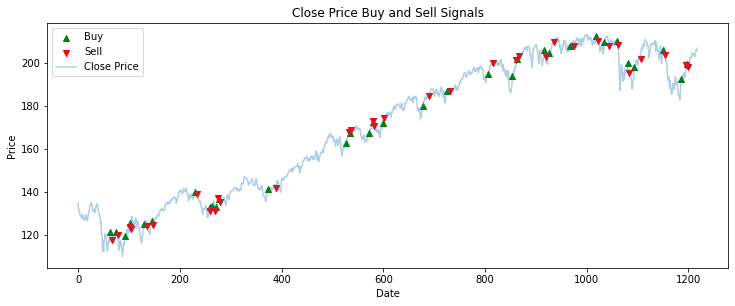

In [27]:

plt.figure(figsize=(12.2,4.5))
plt.scatter(df.index, df['Buy_Signal_Price'], color = 'green', label = 'Buy', marker = '^', alpha = 1)
plt.scatter(df.index, df['Sell_Signal_Price'], color = 'red', label = 'Sell', marker = 'v', alpha = 1)
plt.plot(df['Close'], label = 'Close Price', alpha = 0.35)
plt.title("Close Price Buy and Sell Signals")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc = "upper left")
plt.show()

Result Comparison

Strategy 5 : Pure MACD + Sell 

In [28]:
debug = True
adaptive_stoploss = False
buy = False
sell = False
long_stoploss = None
long_max_profit = None
short_stoploss = None
short_max_profit = None
buy_list = []
sell_list = []

for i in range(len(df)):
    #print(df.Date[i], df.Close[i])
    
    if buy == True and df.Close[i] <= long_stoploss:
        sell_list.append(df.Close[i])
        buy_list.append(np.nan)
        long_stoploss = None
        long_max_profit = None
        buy = False    
        if debug:
            print("Stoploss Hit - Sell at $", df.Close[i])
        
    elif buy == True and df.Close[i] >= long_max_profit:
        if adaptive_stoploss:
            long_stoploss = df.Close[i] * 0.99
            long_max_profit = df.Close[i] * 1.03
            buy_list.append(np.nan)
            sell_list.append(np.nan)
            if debug: 
                print("Max Profit Reached - Updated Stoploss")         
        else:
            sell_list.append(df.Close[i])
            buy_list.append(np.nan)
            long_stoploss = None
            long_max_profit = None
            buy = False   
            if debug: 
                print("Max Profit Reached - Sell at $", df.Close[i])
                
    elif sell == True and df.Close[i] >= short_stoploss:
        buy_list.append(df.Close[i])
        sell_list.append(np.nan)
        short_stoploss = None
        short_max_profit = None
        sell = False
        if debug:
            print("Short Stoploss Hit - Buy Back at $", df.Close[i])
        
    elif sell == True and df.Close[i] <= short_max_profit:
        if adaptive_stoploss:
            short_stoploss = df.Close[i] * 1.01
            short_max_profit = df.Close[i] * 0.97
            buy_list.append(np.nan)
            sell_list.append(np.nan)
            if debug: 
                print("Max Profit Reached - Updated Stoploss")         
        else:
            buy_list.append(df.Close[i])
            sell_list.append(np.nan)
            short_stoploss = None
            short_max_profit = None
            sell = False   
            if debug: 
                print("Short Max Profit Reached - BUy Back at $", df.Close[i])
        
    elif df.MACD_Diff[i] > df.Signal[i] and buy == False and sell == False:
        buy_list.append(df.Close[i])
        sell_list.append(np.nan)
        long_stoploss = df.Close[i] * 0.99
        long_max_profit = df.Close[i] * 1.03
        buy = True
        if debug:
            print("Buy at $", df.Close[i])

            
    elif df.MACD_Diff[i] < df.Signal[i] and buy == True and sell == False:
        sell_list.append(df.Close[i])
        buy_list.append(np.nan)
        long_stoploss = None
        long_max_profit = None
        buy = False
        if debug:
            print("Momentum Changed - Sell at $", df.Close[i])
            
    elif df.MACD_Diff[i] < df.Signal[i] and buy == False and sell == False:
        sell_list.append(df.Close[i])
        buy_list.append(np.nan)
        short_stoploss = df.Close[i] * 1.01
        short_max_profit = df.Close[i] * 0.97
        sell = True
        if debug:
            print("Short Sell at $", df.Close[i])
            
            
    elif df.MACD_Diff[i] > df.Signal[i] and buy == False  and sell == True:
        buy_list.append(df.Close[i])
        sell_list.append(np.nan)
        short_stoploss = None
        short_max_profit = None
        sell = False
        if debug:
            print("Momentum Changed - Buy Back at $", df.Close[i])
            
    else:
        buy_list.append(np.nan)
        sell_list.append(np.nan)
        
        
df['Buy_Signal_Price'] = buy_list
df['Sell_Signal_Price'] = sell_list

Buys = [x for x in df['Buy_Signal_Price']  if math.isnan(x) == False]
Sells = [x for x in df['Sell_Signal_Price']  if math.isnan(x) == False]

if len(Buys) > len(Sells):
    Buys = Buys[:-1]
elif len(Buys) < len(Sells):
    Sells = Sells[:-1]
    
profit5 = sum(Sells) - sum(Buys)
print('Profit: ', profit5)


Short Sell at $ 130.61000061035156
Short Stoploss Hit - Buy Back at $ 132.72999572753906
Short Sell at $ 132.64999389648438
Short Stoploss Hit - Buy Back at $ 134.49000549316406
Short Sell at $ 134.5800018310547
Short Max Profit Reached - BUy Back at $ 130.22000122070312
Short Sell at $ 129.3300018310547
Short Max Profit Reached - BUy Back at $ 120.26000213623047
Short Sell at $ 120.08000183105469
Short Max Profit Reached - BUy Back at $ 112.26000213623047
Short Sell at $ 117.4800033569336
Short Max Profit Reached - BUy Back at $ 112.29000091552734
Buy at $ 117.33000183105469
Stoploss Hit - Sell at $ 114.51000213623047
Buy at $ 112.63999938964844
Max Profit Reached - Sell at $ 116.44000244140625
Buy at $ 118.08000183105469
Stoploss Hit - Sell at $ 116.27999877929688
Buy at $ 117.97000122070312
Max Profit Reached - Sell at $ 121.68000030517578
Buy at $ 122.22000122070312
Stoploss Hit - Sell at $ 120.94000244140625
Buy at $ 117.8499984741211
Stoploss Hit - Sell at $ 115.91999816894531
Bu

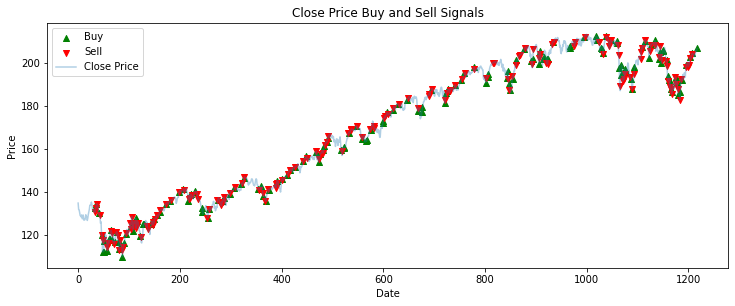

In [29]:

plt.figure(figsize=(12.2,4.5))
plt.scatter(df.index, df['Buy_Signal_Price'], color = 'green', label = 'Buy', marker = '^', alpha = 1)
plt.scatter(df.index, df['Sell_Signal_Price'], color = 'red', label = 'Sell', marker = 'v', alpha = 1)
plt.plot(df['Close'], label = 'Close Price', alpha = 0.35)
plt.title("Close Price Buy and Sell Signals")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc = "upper left")
plt.show()

https://www.youtube.com/watch?v=Gs-_tleyz3Q

Comparison : With Sell option

In [30]:
print(start_date, end_date)
print('Pure MACD', profit1)
print('MACD + EMA100', profit2)
print('MACD + RSI (Oversold)', profit3)
print('MACD + RSI (Trend)', profit4)
print('Pure MACD plus short sell', profit5)


2011-05-28 2016-04-03
Pure MACD 44.76007080078125
MACD + EMA100 21.530006408691406
MACD + RSI (Oversold) 24.250038146972656
MACD + RSI (Trend) 22.040008544921875
Pure MACD plus short sell 31.15019989013672
